## StyleGan Encoding for Children's Drawings

- Using NVIDIA StyleGan: https://github.com/NVlabs/stylegan
- Fine-tuning code: 
- Encoding code: https://github.com/Puzer/stylegan-encoder
  - GOT https://github.com/iyaja/stylegan-encoder

Assumes you have already done this setup and training [stylegan-finetune.ipynb](stylegan-finetune.ipynb)

In [ ]:
# !pip install ipywidgets

In [ ]:
# !jupyter nbextension enable --py widgetsnbextension

In [ ]:
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [ ]:
# !jupyter labextension list

## Encoding Setup

In [ ]:
# !git clone https://github.com/iyaja/stylegan-encoder

Use Augmentor to pre-process input drawings to be square (512x512):

In [ ]:
!pip install Augmentor

### Preprocess inputs

Use Augmentor to pre-process input drawings to be square (512x512):

In [ ]:
pwd

In [ ]:
import Augmentor

In [ ]:
def preprocess_inputs():
    
    source = "/home/jovyan/child-art/data/to_encode"
    dest = "/home/jovyan/child-art/data/square"
    
    p = Augmentor.Pipeline(source, dest, save_format="JPEG")
    p.resize(probability=1.0, width=512, height=512)
    p.process()

In [ ]:
# preprocess_inputs()

## Encoding into Latent Vector

here is a reference https://github.com/iyaja/stylegan-encoder

In [ ]:
cd stylegan-encoder

In [ ]:
pwd

the old way:

In [ ]:
# !python encode_images.py ../data/square/ generated_images/ latent_representations/

do it inline here

In [ ]:
import os
import argparse
import pickle
from tqdm import tqdm_notebook as tqdm
import PIL.Image
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
import config
from encoder.generator_model import Generator
from encoder.perceptual_model import PerceptualModel

In [ ]:
def split_to_batches(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [ ]:
# paths
src_dir = "../data/square/"
generated_images_dir = "../data/generated_images/"
dlatent_dir = "../data/latent_representations/"

# training params
batch_size = 1

# perceptual model params
# image_size = 256
image_size = 512
lr = 1.0
# lr = 4.0
# iterations = 500
# iterations = 1000
# iterations = 5000
# iterations = 8000
iterations = 10000
# iterations = 20000

# generator params
randomize_noise = False#True

In [ ]:
ref_images = [os.path.join(src_dir, x) for x in os.listdir(src_dir)]
ref_images = list(filter(os.path.isfile, ref_images))

if len(ref_images) == 0:
    raise Exception('%s is empty' % src_dir)

os.makedirs(generated_images_dir, exist_ok=True)
os.makedirs(dlatent_dir, exist_ok=True)

In [ ]:
# URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl
# URL_FFHQ = 'https://s3-us-west-2.amazonaws.com/nanonets/blogs/karras2019stylegan-ffhq-1024x1024.pkl'


# Initialize generator and perceptual model
tflib.init_tf()

# Flicker HQ not what I want
# with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
#     generator_network, discriminator_network, Gs_network = pickle.load(f)

# Use my finetuned children's drawings stylegan
model = "../stylegan/results/00021-sgan-custom-2gpu/network-snapshot-011545.pkl"
with open(model, 'rb') as f:
#     _G, _D, Gs = pickle.load(f)
    _G, _D, Gs_network = pickle.load(f)

vgg_layer = 8
# vgg_layer = 9

    
generator = Generator(Gs_network, batch_size, randomize_noise=randomize_noise)
perceptual_model = PerceptualModel(image_size, layer=vgg_layer, batch_size=batch_size)
perceptual_model.build_perceptual_model(generator.generated_image)

In [ ]:
# %%capture

# Optimize (only) dlatents by minimizing perceptual loss between reference and generated images in feature space
for images_batch in tqdm(split_to_batches(ref_images, batch_size), total=len(ref_images)//batch_size):
    names = [os.path.splitext(os.path.basename(x))[0] for x in images_batch]

    perceptual_model.set_reference_images(images_batch)
    op = perceptual_model.optimize(generator.dlatent_variable, iterations=iterations, learning_rate=lr)

    pbar = tqdm(op, leave=False, total=iterations)
    for loss in pbar:
        pbar.set_description(' '.join(names)+' Loss: %.2f' % loss)
    print(' '.join(names), ' loss:', loss)

    # Generate images from found dlatents and save them
    generated_images = generator.generate_images()
    generated_dlatents = generator.get_dlatents()
    for img_array, dlatent, img_name in zip(generated_images, generated_dlatents, names):
        img = PIL.Image.fromarray(img_array, 'RGB')
        img.save(os.path.join(generated_images_dir, f'{img_name}_{lr}_{iterations}.png'), 'PNG')
        np.save(os.path.join(generated_images_dir, f'{img_name}_{lr}_{iterations}.npy'), dlatent)
        np.savetxt(os.path.join(generated_images_dir, f'{img_name}_{lr}_{iterations}.txt'), dlatent, delimiter=',')
#         print(dlatent.shape, dlatent)

    generator.reset_dlatents()

### Interpolate between encoded images

In [2]:
cd stylegan-encoder

/home/jovyan/child-art/stylegan-encoder


In [98]:
import os
import argparse
import pickle
from tqdm import tqdm_notebook as tqdm
import PIL.Image
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
import config
from encoder.generator_model import Generator
from encoder.perceptual_model import PerceptualModel
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.interpolate import interp1d
import cv2
%matplotlib inline

In [63]:
def generate_images(latents):
    images = []
    for latent in latents:
        img = generate_image(latent)
#         img_resized = cv2.resize(img, dsize=(680, 512))
#         images.append(img_resized)
        images.append(img)
    return images

In [64]:
def generate_image(latent_vector):
    latent_vector = latent_vector.reshape((1, 16, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
#     img = PIL.Image.fromarray(img_array, 'RGB')
    return img_array

In [40]:
# def get_dlatent_interpolation(endpoints, num_frames_per, mode, shuffle):
# #     if shuffle:
# #         random.shuffle(endpoints)
#     num_endpoints, dim = len(endpoints), len(endpoints[0])
#     num_frames = num_frames_per * num_endpoints
#     endpoints = np.array(endpoints)
#     latents = np.zeros((num_frames, dim))
#     for e in range(num_endpoints):
#         e1, e2 = e, (e+1)%num_endpoints
#         for t in range(num_frames_per):
#             frame = e * num_frames_per + t
#             r = 0.5 - 0.5 * np.cos(np.pi*t/(num_frames_per-1)) if mode == 'ease' else float(t) / num_frames_per
#             latents[frame, :] = (1.0-r) * endpoints[e1,:] + r * endpoints[e2,:]
#     return latents

# from https://codereview.stackexchange.com/questions/241295/improving-the-performance-of-interpolating-between-two-arrays

def interpolate_points(p1, p2, n_steps=3):
    """Helper function that calculates the interpolation between two points"""
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = (1.0 - ratios) * p1 + ratios * p2
    return vectors

def get_dlatent_interpolation(start, end, numsteps):

    linfit = interp1d([1,5], np.vstack([flat_start, flat_end]), axis=0)

def interpolate_arrays(bounds, n_steps=10):
    """final function that interpolates arrays"""
    bounds = np.array(bounds)

    fun = interp1d(
        x=[0, 1],
        y=bounds.T,
    )
    y = fun(np.linspace(0, 1, n_steps))

    return y

In [41]:
# Loading already learned representations
dlatent_drawing1 = np.load('../data/generated_images/to_encode_original_jasper_giraffe_dragon_food_bw.jpg_8a49d328-7030-4320-806a-10b54cbdfdbe_1.0_10000.npy')
dlatent_drawing2 = np.load('../data/generated_images/to_encode_original_jasper_marker_bw.jpg_7051fc42-627a-4bca-ba0f-b4e495ddd17f_1.0_10000.npy')

In [42]:
# Initialize generator and perceptual model
tflib.init_tf()

# Use my finetuned children's drawings stylegan
model = "../stylegan/results/00021-sgan-custom-2gpu/network-snapshot-011545.pkl"
with open(model, 'rb') as f:
    _G, _D, Gs_network = pickle.load(f)

In [43]:
generator = Generator(Gs_network, batch_size=1, randomize_noise=False)

ValueError: Variable learnable_dlatents already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/home/jovyan/child-art/stylegan-encoder/encoder/generator_model.py", line 16, in create_variable_for_generator
    initializer=tf.initializers.random_normal())
  File "/home/jovyan/child-art/stylegan-encoder/dnnlib/tflib/network.py", line 405, in <listcomp>
    in_expr = [input_builder(name) for input_builder, name in zip(custom_inputs, self.input_names)]
  File "/home/jovyan/child-art/stylegan-encoder/dnnlib/tflib/network.py", line 405, in run
    in_expr = [input_builder(name) for input_builder, name in zip(custom_inputs, self.input_names)]
  File "/home/jovyan/child-art/stylegan-encoder/encoder/generator_model.py", line 29, in __init__
    structure='fixed')
  File "<ipython-input-9-7b42582a3f75>", line 1, in <module>
    generator = Generator(Gs_network, batch_size=1, randomize_noise=False)


In [76]:
print(dlatent_drawing1.shape)
dlatent_drawing1

(16, 512)


array([[-0.34345216, -0.90685475,  0.6651631 , ...,  0.55829   ,
         0.10899293,  1.3066498 ],
       [ 0.20233761,  0.14340404, -0.80748546, ..., -0.07148433,
         0.4212889 ,  0.31527776],
       [-0.7552118 ,  1.3049425 , -0.41515756, ..., -0.422703  ,
        -0.9947377 ,  0.06884057],
       ...,
       [ 0.737706  , -0.5561478 ,  1.137349  , ...,  0.43043053,
        -0.93647516, -1.5742589 ],
       [-0.04577859,  0.37030405, -0.18697907, ...,  0.8095953 ,
        -0.15979001, -0.39059398],
       [ 0.11132009,  0.18649945, -0.5737211 , ...,  0.2804451 ,
         0.3927116 , -1.1088982 ]], dtype=float32)

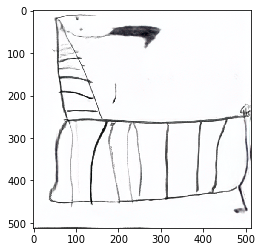

In [99]:
result = generate_image(dlatent_drawing1)
plt.imshow(np.asarray(result))

In [94]:
for i, vec in enumerate(dlatent_drawing1):
    print("{}: {}, {}".format(i, np.mean(vec), np.std(vec)))

0: 0.05376652255654335, 0.6942830085754395
1: 0.05303674936294556, 0.905994176864624
2: 0.06166646629571915, 0.8703665137290955
3: 0.11541883647441864, 0.879482090473175
4: -0.0112064890563488, 0.9669070243835449
5: -0.12395715713500977, 0.9297475218772888
6: -0.014224521815776825, 1.0351133346557617
7: -0.05194117873907089, 0.846204936504364
8: -0.005671674385666847, 0.8548455834388733
9: 0.027212750166654587, 0.7826677560806274
10: -0.024527493864297867, 0.6300080418586731
11: -0.020908454433083534, 0.6231770515441895
12: -0.015061412006616592, 0.5950957536697388
13: -0.039058104157447815, 0.6082179546356201
14: 0.045324746519327164, 0.5708944201469421
15: -0.05609378218650818, 0.6552923321723938


In [120]:
# noise = np.random.randn(16, 512)*2.5
# newvec = dlatent_drawing1 * 0.75 + 0.25 * noise
newvec = dlatent_drawing1*0.01


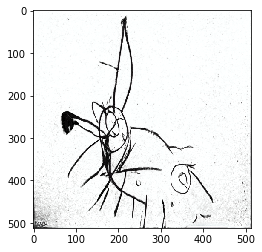

In [121]:
result = generate_image(newvec)
imshow(np.asarray(result))

interpolate betwen images

In [67]:
n_steps = 500
start = dlatent_drawing1.reshape((16 * 512))
end = dlatent_drawing2.reshape((16 * 512))

In [68]:
results = interpolate_arrays([start, end], n_steps=n_steps)

alternate approach: 

```python
qlatent1 = np.random.randn(512)[None, :]
qlatent2 = np.random.randn(512)[None, :]
dlatent1 = Gs.components.mapping.run(qlatent1, None)
dlatent2 = Gs.components.mapping.run(qlatent2, None)

qlatents = np.vstack([(1 - i) * qlatent1 + i * qlatent2 for i in np.linspace(0, 1, 50)])
dlatents = np.vstack([(1 - i) * dlatent1 + i * dlatent2 for i in np.linspace(0, 1, 50)])
dqlatents = Gs.components.mapping.run(qlatents, None)

dimages = Gs.components.synthesis.run(dlatents)
dqimages = Gs.components.synthesis.run(dqlatents)
qimages = Gs.run(qlatents, None)
```

from https://github.com/Puzer/stylegan-encoder/issues/1#issuecomment-466625074

In [69]:
results = results.T

In [70]:
dlatents = results.reshape((n_steps, 16, 512))
dlatents.shape

(500, 16, 512)

In [71]:
gimgs = generate_images(dlatents)

In [75]:
for i,img in enumerate(gimgs+gimgs[::-1]):
    fname = '../data/jasper_interpolation4/frame%05d.jpg' % i
    image_resized = cv2.resize(img, dsize=(680, 512))
    Image.fromarray(image_resized, 'RGB').save(fname)
#     Image.fromarray(img, 'RGB').save(fname)
    